# Prevendo valores do IBOV com algoritmos de machine learning

## Iniciando a coleta e análise exporatória dos dados:

### Importando as blibliotecas que serão utilizadas:

In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import utils

### Carregando o dataframe:

In [150]:
end_data = datetime.today().strftime('%Y-%m-%d')
df = yf.download("^BVSP", start="2004-01-01", end=end_data, progress=False)
df.reset_index(inplace=True)
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,22233.0,22450.0,22208.0,22445.0,22445.0,0
1,2004-01-05,22445.0,23532.0,22445.0,23532.0,23532.0,0
2,2004-01-06,23532.0,23976.0,23180.0,23576.0,23576.0,0
3,2004-01-07,23576.0,23899.0,23320.0,23320.0,23320.0,0
4,2004-01-08,23334.0,23718.0,23122.0,23717.0,23717.0,0


### Analisando o dataframe:

In [117]:
df.shape

(4964, 7)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4964 non-null   datetime64[ns]
 1   Open       4964 non-null   float64       
 2   High       4964 non-null   float64       
 3   Low        4964 non-null   float64       
 4   Close      4964 non-null   float64       
 5   Adj Close  4964 non-null   float64       
 6   Volume     4964 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 271.6 KB


In [119]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4964,2014-01-13 03:07:58.646253056,2004-01-02 00:00:00,2009-01-06 18:00:00,2014-01-15 12:00:00,2019-01-23 06:00:00,2024-01-23 00:00:00,NaN
Open,4964.0,67010.334005,17607.0,49156.75,60711.5,86090.75,134194.0,28177.669079
High,4964.0,67679.241539,18387.0,49689.0,61331.0,87333.0,134392.0,28369.677223
Low,4964.0,66347.161765,17601.0,48507.75,60048.0,85497.5,133832.0,27986.861089
Close,4964.0,67030.177679,17604.0,49174.0,60740.0,86143.75,134194.0,28183.481005
Adj Close,4964.0,67030.177679,17604.0,49174.0,60740.0,86143.75,134194.0,28183.481005
Volume,4964.0,9287878.847703,0.0,1765750.0,3407600.0,6856900.0,232265300.0,23950425.482778


In [120]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

---
#### Colunas:

**Date:** A data da entrada do índice (datetime).

**Close:** O valor de fechamento do índice (float64).

**Open:** O valor de abertura do índice (float64).

**High:** O valor máximo que o índice atingiu (float64).

**Low:** O valor mínimo que o índice atingiu (float64).

**Volume:** O volume de negociações (int).

**Adj Close:** Valor do ajuste de fechamento (float64).


---

#### Visualizando os valores de fechamento e a tendência história:

In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='lines'))

x = np.array(range(len(df)))
y = df['Close'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

fig.add_trace(go.Scatter(x=df['Date'], y=line, mode='lines', name='Linha de Tendência'))

fig.update_layout(showlegend=True, title='Preço de Fechamento do Ibovespa', 
                  xaxis_title='Data', yaxis_title='Preço de Fechamento', xaxis_rangeslider_visible=True, height=800)
fig.show()


### Análise de série temporal (Decomposição)

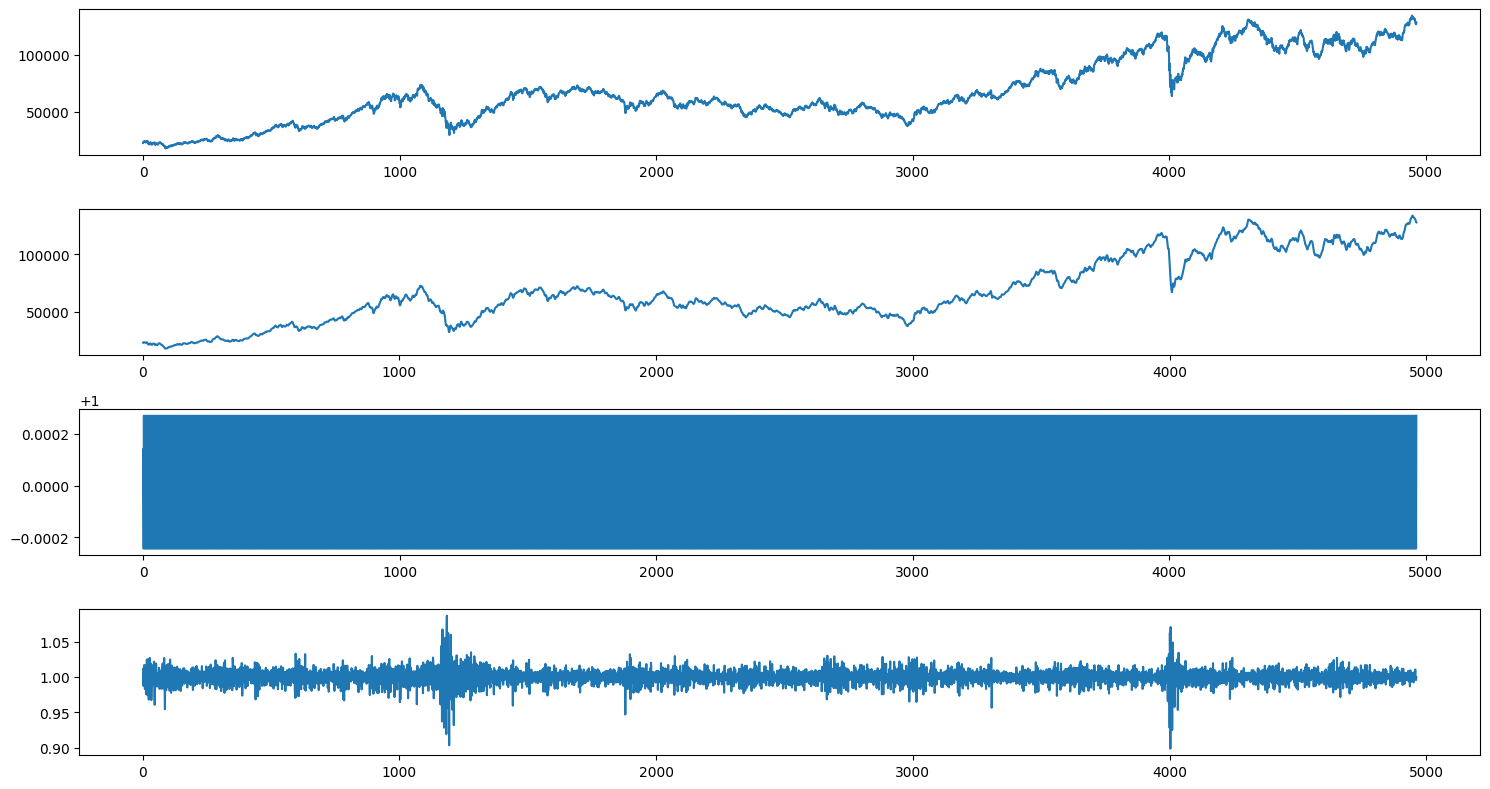

In [122]:
df_dec = df.copy()
df_dec = df_dec['Close']
seasonplot = seasonal_decompose(df_dec, model='multiplicative', period=5) # A bolsa de valores abre 5 dias por semana
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

#### Queda de 2008
A queda de 2008 está relacionada à crise financeira global desencadeada pela bolha imobiliária dos EUA, conhecida como a "crise do subprime". Os efeitos dessa crise foram sentidos em mercados financeiros ao redor do mundo, incluindo a Bovespa, que viu uma redução significativa no valor dos ativos, em linha com a aversão global ao risco e a fuga de capitais.

#### Recuperação de 2009
Em 2009, houve uma recuperação no mercado de ações, incluindo o Ibovespa, em grande parte devido às medidas de estímulo econômico adotadas por governos e bancos centrais em várias partes do mundo. No Brasil, a economia começou a mostrar sinais de melhora, e os investidores recuperaram a confiança, levando a uma recuperação do valor do índice.

#### Queda de 2015
A queda de 2015 pode ser atribuída a uma combinação de fatores, incluindo a desaceleração econômica do Brasil, a crise política interna e a redução dos preços das commodities. Estes eventos tiveram um impacto negativo sobre o mercado de ações brasileiro, resultando em uma performance menos favorável do Ibovespa.

#### Recuperação de 2016
A recuperação do Ibovespa em 2016 foi parcialmente impulsionada pela melhoria do clima político após o impeachment da presidente Dilma Rousseff e a perspectiva de reformas econômicas propostas pelo novo governo. Além disso, a recuperação dos preços das commodities e a melhora do cenário econômico global ajudaram a impulsionar o mercado de ações.

#### Queda de 2020
A queda de 2020 foi desencadeada pela pandemia de COVID-19, que causou um choque sem precedentes nas economias globais e nacionais. O Ibovespa, assim como outros índices ao redor do mundo, sofreu quedas acentuadas devido às incertezas econômicas e ao impacto das medidas de confinamento na atividade econômica.

#### Recuperação de 2020
Surpreendentemente, ainda em 2020, o Ibovespa e outros mercados começaram a se recuperar rapidamente após as quedas iniciais. As respostas políticas, incluindo estímulos fiscais e monetários significativos e o progresso no desenvolvimento de vacinas, ajudaram a restaurar a confiança dos investidores e a promover uma recuperação nos preços das ações.

### Analisando algumas médias móveis: 10, 20, 50 e dias.

In [123]:
df['MA10'] = df['Close'].rolling(10).mean().shift()
df['MA20'] = df['Close'].rolling(20).mean().shift()
df['MA50'] = df['Close'].rolling(50).mean().shift()
df['MA100'] = df['Close'].rolling(100).mean().shift()

# fazer um subplot para cada média móvel usando plotly
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05, subplot_titles=('Média Móvel de 10 dias', 'Média Móvel de 20 dias', 'Média Móvel de 50 dias', 'Média Móvel de 100 dias'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close', line_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA10'], mode='lines', name='MA10'), row=1, col=1)

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close', line_color='blue'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], mode='lines', name='MA20'), row=2, col=1)

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close', line_color='blue'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], mode='lines', name='MA50'), row=3, col=1)

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close', line_color='blue'), row=4, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], mode='lines', name='MA100'), row=4, col=1)

fig.update_layout(showlegend=True, title='Médias Móveis do Ibovespa', xaxis_title='Data', yaxis_title='Preço de Fechamento', height=1500)
fig.show()


#### Vemos no gráfico que os melhores valores para medir a média móvel são 10 e 20 dias porque ainda capturamos tendências nos dados sem ruído.

### Analisando o retorno diário:

In [124]:
df_ret = df.copy()
df_ret = df_ret[['Date', 'Close']]
df_ret.set_index('Date', inplace=True) 
df_ret['DailyReturns'] = df_ret['Close'].pct_change()
df_ret.dropna(inplace=True)
df_ret.head()

,Close,DailyReturns
Date,,
2004-01-05,23532.0,0.048429
2004-01-06,23576.0,0.001870
2004-01-07,23320.0,-0.010859
2004-01-08,23717.0,0.017024
2004-01-09,23917.0,0.008433


In [125]:
trace_daily_returns = go.Scatter(
    x=df_ret.index, 
    y=df_ret['DailyReturns'], 
    mode='markers', 
    name='Retorno Diário',
    marker=dict(color='blue', size=5, opacity=0.3),
    line=dict(color='blue', width=2, dash='dash')
)

# Criar a linha para a média
trace_mean = go.Scatter(
    x=df_ret.index, 
    y=[df_ret['DailyReturns'].mean()]*len(df_ret.index), 
    mode='lines', 
    name='Média',
    line=dict(color='red', width=2)
)

# Criar a linha para o desvio padrão
trace_std = go.Scatter(
    x=df_ret.index, 
    y=[df_ret['DailyReturns'].std()]*len(df_ret.index), 
    mode='lines', 
    name='Desvio Padrão',
    line=dict(color='green', width=2)
)

# Combinar todos os traços no layout do gráfico
fig = go.Figure(data=[trace_daily_returns, trace_mean, trace_std])

# Atualizar o layout do gráfico
fig.update_layout(
    title='Retorno Diário do Ibovespa',
    xaxis_title='Data',
    yaxis_title='Retorno Diário',
    legend_title='Legenda',
    hovermode='closest',
    height=600,
    xaxis_rangeslider_visible=True
)

# Adicionar grade ao gráfico
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Exibir o gráfico
fig.show()




### Volatilidade

Períodos de alta volatilidade podem ser observados no gráfico, que muitas vezes correspondem a eventos econômicos ou políticos significativos. Por exemplo, picos de volatilidade podem ​​estar associados a crises financeiras, mudanças políticas, ou outros eventos que causam incerteza no mercado.

### Analisando o retorno diário médio usando um histograma:

In [126]:
histogram = go.Histogram(
    x=df_ret['DailyReturns'],
    nbinsx=50,
    marker_color='blue',
)

layout = go.Layout(
    title='Histograma de Retornos Diários',
    xaxis=dict(title='Retorno Diário'),
    yaxis=dict(title='Frequência'),
    bargap=0.2,
)

fig = go.Figure(data=[histogram], layout=layout)

fig.show()

### Analisando a correlação dos dados:

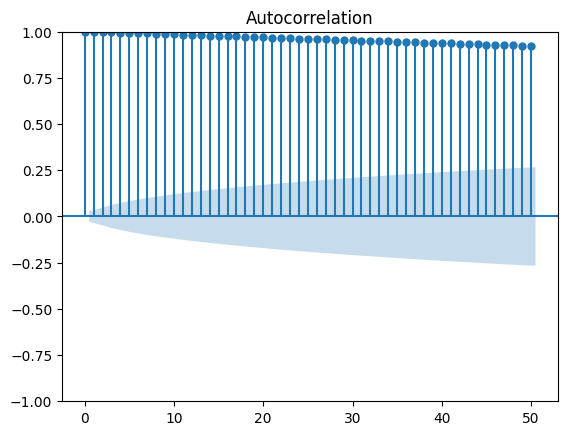

In [127]:
df_corr = df.copy()
df_corr = df_corr['Close']
df_corr = df_corr.to_frame()
sm.graphics.tsa.plot_acf(df_corr, lags=50, alpha=0.05)
plt.show()

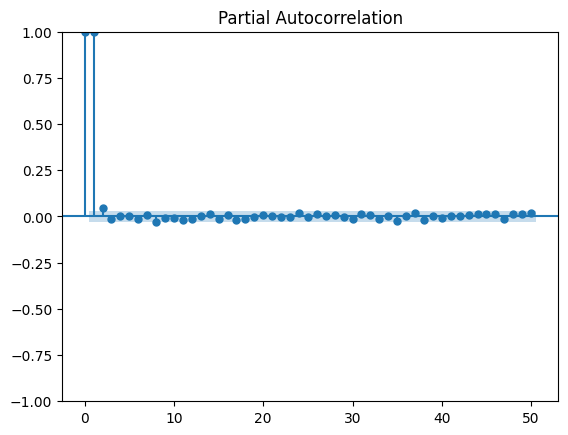

In [128]:
sm.graphics.tsa.plot_pacf(df_corr, lags=50, alpha=0.05)
plt.show()

#### Autocorrelação

Ambos os gráficos mostram que existe autocorrelação nos dados do Ibovespa. Isso é esperado em séries temporais financeiras, onde os preços podem ser influenciados por seus próprios valores históricos.

### Analisando a Estacionaridade da Série Temporal:

In [144]:
def test_stationarity(timeseries):
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import adfuller

    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if (dfoutput[1] < 0.05):
        print('Conclusão: A série é Estacionária.')
    else:
        print('Conclusão: A série NÂO é Estacionária.')

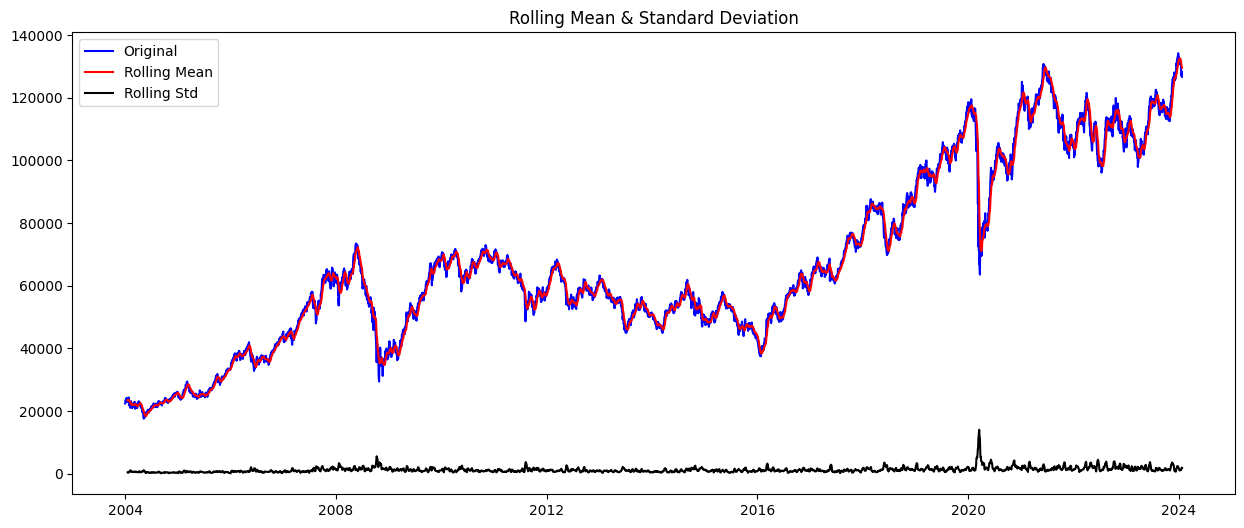

Results of Dickey Fuller Test:
Test Statistic                   -1.076296
p-value                           0.724432
#Lags Used                       11.000000
Number of Observations Used    4952.000000
Critical Value (1%)              -3.431671
Critical Value (5%)              -2.862124
Critical Value (10%)             -2.567081
dtype: float64
Conclusão: A série NÂO é Estacionária.


In [145]:
df_test = df.copy()
df_test = df_test[['Date', 'Close']]
df_test.set_index('Date', inplace=True)
df_test.dropna(inplace=True)

utils.test_stationarity(df_test)

#### Conclusão:

**A série NÃO é Estacionária.**

## Por que escolhi trabalhar com dados pós-2020?

1. **Eventos Extraordinários**: Os períodos anteriores a 2021 foram marcados por eventos atípicos e choques externos, como a crise financeira de 2008, a crise política brasileira de 2015 e a pandemia de COVID-19 em 2020. Esses eventos podem ser considerados outliers em termos de modelagem preditiva, pois são influenciados por fatores que não são recorrentes ou que não refletem as condições normais de mercado.

2. **Mudanças Estruturais**: Cada um desses eventos levou a mudanças estruturais nos mercados financeiros e na economia como um todo. Isso inclui mudanças nas políticas econômicas, medidas de estímulo e a dinâmica do mercado em resposta à crise. Ao começar o conjunto de dados de 2021, é possível focar em um período que representa um "novo normal" após a acomodação dessas mudanças.

3. **Estabilidade e Previsibilidade**: Os modelos preditivos se beneficiam de estabilidade nos dados para capturar tendências e padrões subjacentes. Iniciar o conjunto de dados pós-2020 pode proporcionar um ambiente de mercado mais estável e previsível, eliminando a volatilidade extrema e as condições de mercado atípicas causadas por crises.

4. **Relevância Atual**: Utilizar dados mais recentes garante que o modelo seja treinado com informações que são mais relevantes para as condições atuais do mercado. Isso é particularmente importante em mercados financeiros, onde as condições econômicas e as dinâmicas de mercado podem mudar rapidamente.

5. **Redução de Viés de Eventos Passados**: Excluir dados de períodos marcados por crises graves pode ajudar a reduzir o viés que esses eventos podem introduzir no modelo, garantindo que o modelo não sobrevalorize a probabilidade de ocorrência de eventos semelhantes no futuro.

## Considerações para o treinamento:

**Feriados Americanos:** Nos dias em que não tem bolsa nos EUA, o volume de negociações na BMF cai muito e acaba não seguindo algumas tendências de mercado.

## Por que escolhi o Prophet?

1. **Simplicidade e Facilidade de Uso:**
   - O Prophet foi desenvolvido para ser acessível e fácil de usar, mesmo para aqueles que não são especialistas em estatística ou aprendizado de máquina.

2. **Flexibilidade com Sazonalidades:**
   - O Prophet lida muito bem com dados de séries temporais que apresentam padrões de sazonalidade complexos e múltiplos, como sazonalidades anuais, semanais e diárias. Além disso, ele pode acomodar feriados e eventos especiais, o que pode ser particularmente útil para dados de mercado.

3. **Robustez a Dados Faltantes e Mudanças na Tendência:**
   - O modelo é robusto a dados faltantes e mudanças na tendência, o que o torna adequado para conjuntos de dados que podem não ser perfeitamente consistentes ou completos.

4. **Desempenho e Precisão:**
   - Embora modelos como LSTM, GRU ou DNNs possam oferecer maior precisão em algumas situações, o Prophet frequentemente fornece um bom equilíbrio entre precisão e complexidade. Modelos mais complexos como redes neurais exigem uma grande quantidade de dados e poder computacional, além de serem mais sensíveis a overfitting.

5. **Interpretabilidade dos Resultados:**
   - O Prophet fornece componentes modelados (tendência, sazonalidade, feriados) de forma clara, tornando os resultados mais interpretáveis. Em contraste, modelos como redes neurais são frequentemente considerados "caixas-pretas", onde a interpretação dos resultados pode ser desafiadora.

6. **Rapidez no Desenvolvimento e Testes:**
   - Implementar e testar o Prophet geralmente leva menos tempo do que construir e ajustar modelos de redes neurais.

7. **Menor Necessidade de Ajustes Finos:**
   - Enquanto modelos como LSTM e DNNs podem requerer um ajuste fino extenso dos hiperparâmetros, o Prophet tem menos parâmetros para ajustar, o que facilita o processo de modelagem.

8. **Feriados:**
   - Por fim, escolhi o Prophet por que ele tem a facilidade de considerar os feriádos que interferem no IBOV, como feriados americanos, nacionais e do estado de SP.